In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

Let's load the parquetfile we saved in notebook 1. You will need to change the filename in the config file!

In [3]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': '/Users/floridomeacci/Documents/HU/MADS-DAV/data/processed/this.parq',
 'inputpath': '/Users/floridomeacci/Documents/HU/MADS-DAV/data/processed/this.csv',
 'datetime_format': '%m/%d/%y, %H:%M',
 'drop_authors': []}

In [4]:
root = Path("..").resolve()
processed = root / Path(config["processed"])
datafile = processed / config["current"]
if not datafile.exists():
    logger.warning(
        f"{datafile} does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Note how datatypes have been preserved.

In [5]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp    datetime64[ns, UTC]
message                   object
author                    object
has_emoji                   bool
dtype: object

In [6]:
df.head()

,timestamp,message,author,has_emoji
0,2022-02-17 13:15:00+00:00,Wohoo Birthday boy @⁨Fei⁩ 🎉🎉🎉🎉🎉🎉,jesting-duck,True
1,2022-02-17 13:15:00+00:00,Many wishes!!! From all of us🤗😘😘🎊,jesting-duck,True
2,2022-02-17 13:28:00+00:00,Auguri 🎂🎂🎉🎉,translucent-dinosaur,True
3,2022-02-17 13:35:00+00:00,Thank you guys! 🥰🥰 so many wishes!,foamy-jackal,False
4,2022-02-17 13:48:00+00:00,And good luck tomorrow!!!!! 🤞🤞🤞,jesting-duck,False


Let's count the amount of messages, per author.

In [7]:
p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [8]:
topk_authors = list(topk.index)

In [9]:
df["is_topk"] = df["author"].apply(lambda x: x in topk_authors)
df.head()

,timestamp,message,author,has_emoji,is_topk
0,2022-02-17 13:15:00+00:00,Wohoo Birthday boy @⁨Fei⁩ 🎉🎉🎉🎉🎉🎉,jesting-duck,True,True
1,2022-02-17 13:15:00+00:00,Many wishes!!! From all of us🤗😘😘🎊,jesting-duck,True,True
2,2022-02-17 13:28:00+00:00,Auguri 🎂🎂🎉🎉,translucent-dinosaur,True,True
3,2022-02-17 13:35:00+00:00,Thank you guys! 🥰🥰 so many wishes!,foamy-jackal,False,True
4,2022-02-17 13:48:00+00:00,And good luck tomorrow!!!!! 🤞🤞🤞,jesting-duck,False,True


Text(0.5, 1.0, 'Sending the most messages...')

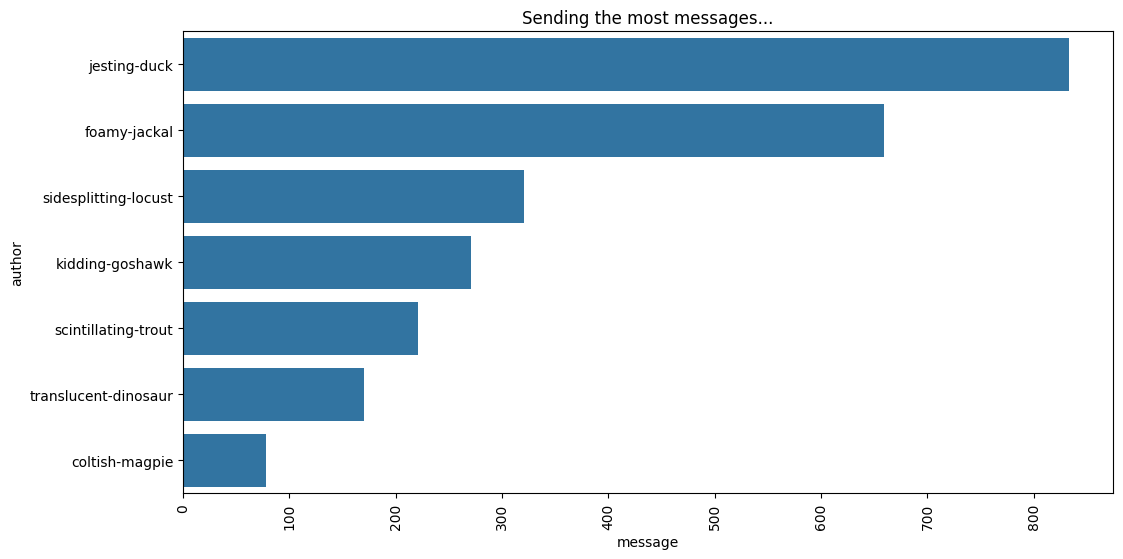

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(y=p1.index[:k], x="message", data=topk)
plt.xticks(rotation=90)
plt.title("Sending the most messages...")

Maybe tweak the colors a bit

Text(0.5, 1.0, 'Sending the most messages...')

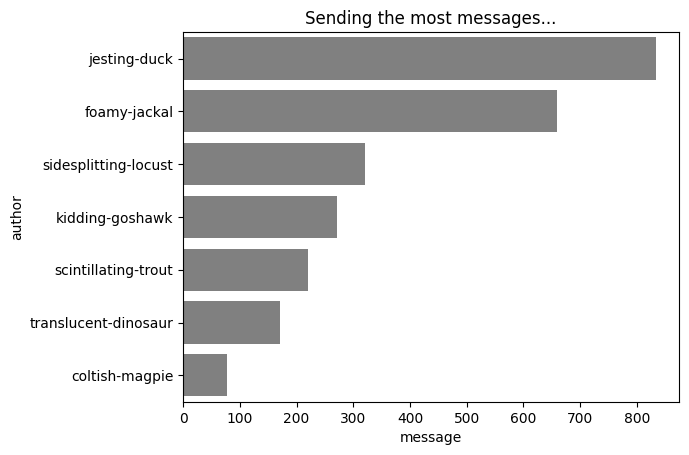

In [11]:
colors = [0 if x < 1000 else 1 for x in topk.message]
custom_palette = {0: "grey", 1: "red"}
sns.barplot(
    y=p1.index[:k],
    x="message",
    hue=colors,
    data=topk,
    palette=custom_palette,
    legend=False,
)
plt.title("Sending the most messages...")

Let's calculate the average message length.

Text(0.5, 1.0, 'Sending the longest messages...')

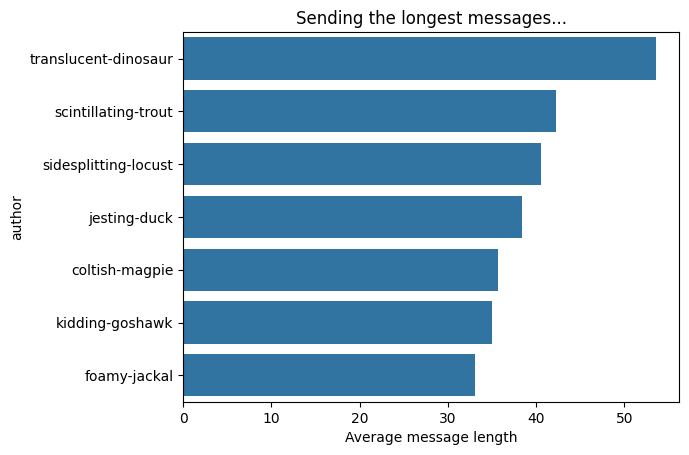

In [12]:
df["message_length"] = df["message"].str.len()
p1 = (
    df[["author", "message_length"]]
    .groupby("author")
    .mean()
    .sort_values("message_length", ascending=False)
)
k = 15
topk = p1[:k]
sns.barplot(y=p1.index[:k], x="message_length", data=topk)
plt.xlabel("Average message length")
plt.title("Sending the longest messages...")

Create a simple regex to look for links in the messages and add that as a feature:

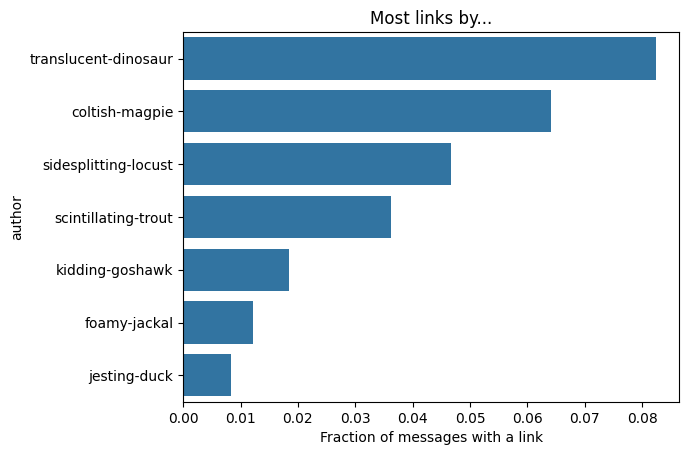

In [13]:
has_link = r"http"
df["has_link"] = df["message"].str.contains(has_link)
if df["has_link"].sum() > 0:
    p1 = (
        df[["author", "has_link"]]
        .groupby("author")
        .mean()
        .sort_values("has_link", ascending=False)
    )

    k = 15
    topk = p1[:k]
    sns.barplot(y=p1.index[:k], x="has_link", data=topk)
    plt.xlabel("Fraction of messages with a link")
    plt.title("Most links by...")
else:
    logger.info("No links found in the messages")

Aggregate the emojis per user (can you change between sum and mean?)

Text(0.5, 1.0, "Are emoji's non-verbal?")

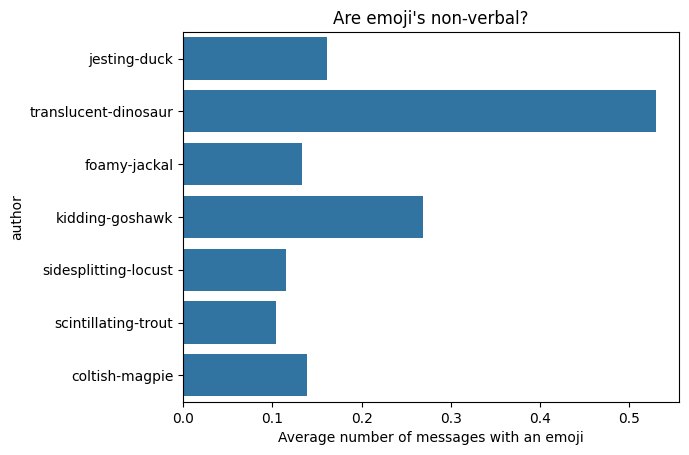

In [14]:
p2 = (
    df[["author", "has_emoji"]]
    .groupby("author")
    .agg(["sum", "mean"])
    .sort_values(("has_emoji", "sum"), ascending=False)
)

p2.columns = p2.columns.droplevel(0)
topk = p2[:k]
sns.barplot(y=p2.index[:k], x="mean", data=topk)
plt.xlabel("Average number of messages with an emoji")
plt.title("Are emoji's non-verbal?")

Let's add a cateory, based on the time when authors send a message:

In [15]:
import pandas as pd

# Define the time ranges
time_ranges = ["00:00", "06:00", "08:00", "17:30", "22:00", "23:59"]
# Define the category labels
categories = ["night", "morning", "worktimes", "evening", "late"]
# Categorize the timestamp column
df["timestamp_category"] = pd.cut(
    df["timestamp"].dt.time.astype(str),
    bins=time_ranges,
    labels=categories,
    right=False,
)
# Display the updated dataframe
df

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category
0,2022-02-17 13:15:00+00:00,Wohoo Birthday boy @⁨Fei⁩ 🎉🎉🎉🎉🎉🎉,jesting-duck,True,True,33.0,False,worktimes
1,2022-02-17 13:15:00+00:00,Many wishes!!! From all of us🤗😘😘🎊,jesting-duck,True,True,33.0,False,worktimes
2,2022-02-17 13:28:00+00:00,Auguri 🎂🎂🎉🎉,translucent-dinosaur,True,True,11.0,False,worktimes
3,2022-02-17 13:35:00+00:00,Thank you guys! 🥰🥰 so many wishes!,foamy-jackal,False,True,34.0,False,worktimes
4,2022-02-17 13:48:00+00:00,And good luck tomorrow!!!!! 🤞🤞🤞,jesting-duck,False,True,31.0,False,worktimes
...,...,...,...,...,...,...,...,...
2559,2025-09-08 08:47:00+00:00,<Media omitted>,coltish-magpie,False,True,15.0,False,worktimes
2560,2025-09-08 08:47:00+00:00,First day🎉🥲,coltish-magpie,True,True,11.0,False,worktimes
2561,2025-09-08 08:47:00+00:00,So cute!!!! With the plantje 🤩🤗,jesting-duck,False,True,31.0,False,worktimes
2562,2025-09-08 08:47:00+00:00,Cute! With little pot,foamy-jackal,False,True,21.0,False,worktimes


Now we can group and count the categories:

In [16]:
# Group the dataframe by 'author' and 'timestamp_category', and count the occurrences
p3 = df.groupby(["author", "timestamp_category"]).size().unstack()

# Calculate the fraction of each category for every author
p3_frac = p3.div(p3.sum(axis=1), axis=0)
p3_frac

timestamp_category,night,morning,worktimes,evening,late
author,,,,,
coltish-magpie,0.000000,0.000000,0.696203,0.265823,0.037975
foamy-jackal,0.006033,0.004525,0.542986,0.300151,0.146305
jesting-duck,0.003584,0.005974,0.526882,0.346476,0.117085
kidding-goshawk,0.011029,0.000000,0.503676,0.404412,0.080882
scintillating-trout,0.004525,0.004525,0.674208,0.153846,0.162896
sidesplitting-locust,0.003115,0.012461,0.694704,0.242991,0.046729
translucent-dinosaur,0.017647,0.005882,0.611765,0.288235,0.076471


Let's use plotly the create a stacked bar chart:

In [17]:
p4 = p3_frac.reset_index().melt(id_vars="author")
p4.head()

,author,timestamp_category,value
0,coltish-magpie,night,0.000000
1,foamy-jackal,night,0.006033
2,jesting-duck,night,0.003584
3,kidding-goshawk,night,0.011029
4,scintillating-trout,night,0.004525


In [18]:
p4_filtered = p4[p4["author"].isin(topk_authors)]

In [24]:
import plotly.express as px

fig = px.bar(
    p4_filtered, y="author", x="value", color="timestamp_category", barmode="stack"
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Let's extract the minimum and maximum time of the messages for every author, and convert that to a decimal fraction:

In [ ]:
df["hour"] = df["timestamp"].dt.time
summary_df = df.groupby("author")["hour"].agg(["min", "max"]).reset_index()


def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour


summary_df["min_x_values"] = summary_df["min"].apply(convert_to_decimal_hours)
summary_df["max_x_values"] = summary_df["max"].apply(convert_to_decimal_hours)

# Drop the original 'min' and 'max' columns as they are no longer needed
summary_df = summary_df.drop(["min", "max"], axis=1)
summary_df.head()

With this, we can create a nice barbell chart. Try to add colors for your own chart!

In [ ]:
# Create a larger plot
plt.figure(figsize=(10, 8))

# Create scatter plots
sns.scatterplot(data=summary_df, x="min_x_values", y="author", color="grey")
sns.scatterplot(data=summary_df, x="max_x_values", y="author", color="grey")

# Add lines
for index, row in summary_df.iterrows():
    plt.plot(
        [row["min_x_values"], row["max_x_values"]],
        [row["author"], row["author"]],
        color="grey",
    )


# Adjust the font size of the y-axis labels if needed
plt.yticks(fontsize=10)

# Show the plot
plt.show()

Another approach for comparing is to create a heatmap:

In [ ]:
df["day_of_week"] = df["timestamp"].dt.dayofweek
author_day_counts = df.groupby(["author", "day_of_week"]).size().unstack(fill_value=0)
author_day_percentages = author_day_counts.div(author_day_counts.sum(axis=1), axis=0)


filtered = author_day_percentages.loc[topk_authors]
sns.heatmap(filtered, annot=True, fmt=".2f", linewidths=0.5, cmap="vlag")
plt.xticks(
    ticks=range(7),
    labels=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    rotation=45,
)
plt.title("Heatmap")

Let's save all the new features we added:

In [ ]:
datafile

In [ ]:
df.to_parquet(datafile, index=False)